<a href="https://colab.research.google.com/github/aslestia/ACS_2025/blob/main/ACS_jurnal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# REINFORCE & Actor–Critic on CartPole (with Entropy Bonus & Optimizer Options)

Notebook ini berisi implementasi **REINFORCE** (Monte Carlo policy gradient) dan **Actor–Critic** (on‑policy, 1‑step TD)
untuk lingkungan **CartPole**. Fitur yang disertakan:
- Kompatibel `gym` **atau** `gymnasium`
- **Optimizer alternatif**: Adam / AdamW / RMSprop
- **Entropy bonus** (membantu eksplorasi)
- **Gradient clipping** untuk stabilitas
- Utilitas **moving average** untuk monitoring kinerja
- **Plot** reward per‑episode dan moving average (tanpa styling khusus)

> Catatan: Jika menjalankan di lingkungan baru, jalankan sel `pip install` terlebih dahulu (atau sesuaikan sesuai environment Anda).


In [ ]:
# ==== (Opsional) Install packages ====
# Gunakan salah satu sesuai ketersediaan lingkungan Anda.
# Jika sudah terpasang, Anda bisa melewati sel ini.

# %pip install torch --quiet
# %pip install gymnasium[classic-control] --quiet

# atau (jika memakai gym lama):
# %pip install gym==0.26.2 --quiet
# %pip install matplotlib --quiet

In [ ]:
from warnings import filterwarnings
filterwarnings('ignore')

import os, random, numpy as np, torch, csv, math
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
import yfinance as yf
import pandas as pd

try:
    import gymnasium as gym
    from gymnasium import spaces
    from gymnasium.envs.registration import register
    GYMN = 'gymnasium'
    print('✅ Using gymnasium')
except ImportError:
    import gym
    from gym import spaces
    from gym.envs.registration import register
    GYMN = 'gym'
    print('⚠️ Using classic gym')

✅ Using gymnasium


In [ ]:
def set_seed(seed=42):
    """Mengatur seed untuk reproduktifitas."""
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

def reset_env(env, seed):
    """Mengatur ulang environment dengan seed yang diberikan."""
    return env.reset(seed=seed)[0]

def step_env(env, action):
    """Melakukan satu langkah di environment."""
    return env.step(action)

def make_optimizer(params, opt_name='adam', lr=1e-3, weight_decay=0.0):
    """Membuat optimizer."""
    if opt_name.lower() == 'adam':
        return torch.optim.Adam(params, lr=lr, weight_decay=weight_decay)
    elif opt_name.lower() == 'rmsprop':
        return torch.optim.RMSprop(params, lr=lr, weight_decay=weight_decay)
    else:
        raise ValueError(f"Optimizer {opt_name} tidak didukung.")

def linear_schedule(start_value, end_value, current_step, total_steps):
    """Penjadwalan linear dari start_value ke end_value."""
    fraction = min(current_step / total_steps, 1.0)
    return start_value + fraction * (end_value - start_value)

class RunningNorm:
    """Normalisasi berjalan untuk observasi."""
    def __init__(self):
        self.mean = 0.0
        self.var = 1.0
        self.count = 0
        self.eps = 1e-4

    def update(self, x):
        """Memperbarui statistik dengan observasi baru (x)."""
        x = np.asarray(x)
        self.count += 1
        delta = x - self.mean
        self.mean += delta / self.count
        self.var += delta * (x - self.mean)

    def norm(self, x):
        """Normalisasi observasi (x)."""
        std = np.sqrt(self.var / (self.count if self.count > 1 else 1))
        return (x - self.mean) / (std + self.eps)

class Meter:
    """
    Pencatat hadiah dan rata-rata bergerak.
    """
    def __init__(self, window=20):
        self.rewards = []
        self.window = window
        self.moving_averages = []

    def push(self, reward):
        """Menambahkan hadiah episode dan menghitung rata-rata bergerak terbaru."""
        self.rewards.append(reward)

        # Hitung rata-rata bergerak terbaru
        if len(self.rewards) >= self.window:
            current_avg = np.mean(self.rewards[-self.window:])
        else:
            # Jika belum mencapai window, hitung rata-rata dari semua reward yang ada
            current_avg = np.mean(self.rewards) if self.rewards else 0.0

        self.moving_averages.append(current_avg)

    def get_last_moving_avg(self):
        """Mengembalikan rata-rata bergerak terakhir (skalar)."""
        return self.moving_averages[-1] if self.moving_averages else 0.0

    def get_all_moving_avgs(self):
        """Mengembalikan list lengkap dari semua rata-rata bergerak (untuk plotting)."""
        return self.moving_averages

def plot_curve(rewards, mv, title='Learning Curve'):
    plt.figure(figsize=(8,4.5))
    plt.plot(rewards, label='Reward per episode')
    if mv is not None:
        plt.plot(mv, label='Moving average')
    plt.title(title)
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.legend(); plt.show()

def make_optimizer(params, opt_name='adam', lr=1e-3, weight_decay=0.0):
    o = opt_name.lower()
    if o == 'adamw':
        return optim.AdamW(params, lr=lr, weight_decay=weight_decay)
    if o == 'rmsprop':
        return optim.RMSprop(params, lr=lr, weight_decay=weight_decay, momentum=0.0)

    return optim.Adam(params, lr=lr, weight_decay=weight_decay)

def linear_schedule(start, end, t, T):
    frac = min(max(t / max(T,1), 0.0), 1.0)
    return start + (end - start) * frac

# Multi Stock Return Environment

In [ ]:
class MultiStockReturnEnv(gym.Env):
    metadata = {'render.modes': ['human']}

    def __init__(self, returns_df, initial_balance=10000, transaction_cost_pct=0.001,
                 reward_scale=1e-3, max_share_unit=1.0, clip_ret=0.2, debug=False):
        super().__init__()
        # data
        self.raw_df = returns_df.reset_index(drop=True).copy()
        self.df = self.raw_df.fillna(0.0).astype(float)
        self.n_stocks = self.df.shape[1]

        # params
        self.initial_balance = float(initial_balance)
        self.transaction_cost_pct = float(transaction_cost_pct)
        self.reward_scale = float(reward_scale)
        self.max_share_unit = float(max_share_unit)  # scaling factor for holdings
        self.clip_ret = float(clip_ret)
        self.debug = bool(debug)

        # observation: normalized returns (n_stocks) + cash_norm + shares_norm_mean
        obs_dim = self.n_stocks + 2
        high = np.ones(obs_dim, dtype=np.float32) * np.finfo(np.float32).max
        self.observation_space = spaces.Box(low=-high, high=high, dtype=np.float32)

        # discrete action space (easy baseline)
        self.action_space = spaces.Discrete(3)
        self.scaler = StandardScaler()
        self.scaler.fit(self.df.values)

        # state
        self.reset()

    def _get_obs(self):
        row = np.nan_to_num(self.df.loc[self.current_step].values, nan=0.0).astype(np.float32)
        row = np.clip(row, -self.clip_ret, self.clip_ret)

        try:
            row_scaled = self.scaler.transform(row.reshape(1, -1)).flatten()
        except Exception:
            row_scaled = row

        cash_norm = np.clip(self.balance / (self.initial_balance * 10.0), -1e3, 1e3)  # bounded
        shares_norm = np.clip(np.mean(self.shares_held) / (self.max_share_unit + 1e-9), -1e3, 1e3)
        obs = np.concatenate([row_scaled.astype(np.float32), np.array([cash_norm, shares_norm], dtype=np.float32)])
        obs = np.nan_to_num(obs, nan=0.0, posinf=1e9, neginf=-1e9)
        return obs

    def step(self, action):
        info = {}

        rets = np.nan_to_num(self.df.loc[self.current_step].values, nan=0.0).astype(np.float64)
        rets = np.clip(rets, -self.clip_ret, self.clip_ret)

        prev_total = float(self.total_asset)

        if action == 1:  # buy all available cash, proportional across stocks
            cash_available = self.balance * (1.0 - self.transaction_cost_pct)
            units_per_stock = (cash_available / self.initial_balance) / max(1.0, self.n_stocks)
            self.shares_held += units_per_stock
            self.balance = 0.0
        elif action == 2:  # sell all (liquidate)
            mean_rets = np.mean(rets)
            proceeds = np.sum(self.shares_held) * self.initial_balance * (1.0 + mean_rets)
            proceeds *= (1.0 - self.transaction_cost_pct)
            self.balance += proceeds
            self.shares_held[:] = 0.0

        try:
            self.shares_held = self.shares_held * (1.0 + rets)
        except Exception:
            if np.isscalar(self.shares_held):
                self.shares_held = np.array([self.shares_held] * self.n_stocks)
                self.shares_held = self.shares_held * (1.0 + rets)
            else:
                self.shares_held = np.zeros(self.n_stocks)

        self.shares_held = np.nan_to_num(self.shares_held, nan=0.0, posinf=1e9, neginf=-1e9)
        self.total_asset = float(self.balance + np.sum(self.shares_held) * self.initial_balance)

        reward = (self.total_asset - prev_total) * self.reward_scale
        reward = float(np.nan_to_num(reward, nan=0.0))
        reward = float(np.clip(reward, -1.0, 1.0))

        if self.debug:
            if (np.isnan(reward) or np.isnan(self.total_asset) or np.isnan(self.shares_held).any()):
                print(f"[DEBUG NaN] step={self.current_step} reward={reward} total={self.total_asset}")
            if abs(reward) > 0.5:
                print(f"[DEBUG LargeReward] step={self.current_step} reward={reward} total={self.total_asset}")

        self.current_step += 1
        done = False
        if self.current_step >= len(self.df) - 1:
            done = True

        obs = self._get_obs()
        terminated, truncated = done, False
        return obs, reward, terminated, truncated, info

    def reset(self, seed=None, options=None):
        try:
            super().reset(seed=seed)
        except TypeError:
            pass
        self.current_step = 0
        self.balance = float(self.initial_balance)
        self.shares_held = np.zeros(self.n_stocks, dtype=np.float64)
        self.total_asset = float(self.initial_balance)
        obs = self._get_obs()
        return obs, {}

    def render(self, mode='human'):
        print(f"Step {self.current_step} | Total Asset: {self.total_asset:.2f}")

tickers = ['AAPL', 'MSFT', 'GOOG',
           'AMZN', 'META', 'TSLA',
           'NVDA', 'JPM', 'V', 'NFLX']

dfs = []
for t in tickers:
    df_t = yf.download(t, period='5y', interval='1d', progress=False)
    df_t = df_t[['Close']].rename(columns={'Close': t})
    dfs.append(df_t)

df_all = pd.concat(dfs, axis=1).dropna()
returns = df_all.pct_change().dropna().reset_index(drop=True)

env_id = "MultiStockReturn-v0"
if env_id in gym.registry:
    del gym.registry[env_id]

register(
    id=env_id,
    entry_point=lambda: MultiStockReturnEnv(
        returns_df=returns,
        reward_scale=1e-3
    ),
    max_episode_steps=len(returns) - 1,
)

print("Registered envs:", [spec.id for spec in gym.registry.values() if "MultiStockReturn" in spec.id])

env = gym.make(env_id)
obs, _ = env.reset()
print("obs shape:", obs.shape, "obs sample:", obs[:5])
step_out = env.step(0)
print("step output lengths:", len(step_out))

Registered envs: ['MultiStockReturn-v0']
obs shape: (12,) obs sample: [0.44494796 0.15327446 0.06848973 0.00547941 0.22848128]
step output lengths: 5



## REINFORCE (Monte Carlo Policy Gradient)

- Mengumpulkan satu trajectory penuh per episode.
- Menghitung **return** `G_t` (diskonto) lalu memutakhirkan parameter dengan objective `-\sum_t G_t \log \pi_\theta(a_t|s_t)`.
- **Entropy bonus** opsional untuk menjaga eksplorasi.
- Normalisasi returns per-episode sebagai **baseline sederhana** (pengurang varians).


In [ ]:
class PolicyNet(nn.Module):
    """Jaringan Kebijakan murni (untuk REINFORCE tanpa baseline V-value)."""
    def __init__(self, obs_dim, act_dim, hidden=128, dropout=0.0):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_dim, hidden),
            nn.LayerNorm(hidden),
            nn.LeakyReLU(0.1),

            nn.Linear(hidden, hidden),
            nn.LayerNorm(hidden),
            nn.LeakyReLU(0.1),

            nn.Dropout(dropout),
            nn.Linear(hidden, act_dim)
        )

        for m in self.net:
            if isinstance(m, nn.Linear):
                nn.init.orthogonal_(m.weight, gain=1.0)
                nn.init.constant_(m.bias, 0.0)

    def forward(self, x):
        return torch.distributions.Categorical(logits=self.net(x))

class PolicyBaseline(nn.Module):
    """Jaringan Policy dan Value (untuk REINFORCE dengan baseline V-value)."""
    def __init__(self, obs_dim, act_dim, hidden=128):
        super().__init__()
        self.body = nn.Sequential(nn.Linear(obs_dim, hidden), nn.ReLU())
        self.pi_head = nn.Linear(hidden, act_dim)
        self.v_head  = nn.Linear(hidden, 1)

    def forward(self, x):
        h = self.body(x)
        dist = torch.distributions.Categorical(logits=self.pi_head(h))
        v    = self.v_head(h).squeeze(-1)
        return dist, v

# --- Core RL Calculations ---

def compute_returns(rewards, gamma):
    """Menghitung discounted returns (G_t)."""
    G, out = 0.0, []
    for r in reversed(rewards):
        G = r + gamma * G
        out.append(G)
    out.reverse()
    return torch.tensor(out, dtype=torch.float32)

def compute_cvar_value(returns, alpha=0.1):
    """Menghitung CVaR dari returns (bukan loss)."""
    sorted_returns, _ = torch.sort(returns)
    n = len(sorted_returns)
    k = max(1, math.ceil(alpha * n))
    cvar = sorted_returns[:k].mean()
    return cvar

# --- Training Function ---

def train_reinforce(env_name='CartPole-v1', episodes=800, gamma=0.99, seed=42,
                                   opt_name='adam', lr=1e-3, weight_decay=0.0, hidden=256,
                                   use_baseline=True,
                                   var=False, cvar=False, evar=False,
                                   alpha=0.1, beta_risk=0.5, # alpha untuk VaR/CVaR, beta_risk untuk EVaR
                                   entropy_start=0.02, entropy_end=0.001,
                                   grad_clip=0.5, render=False, window=20,
                                   csv_filename='reinforce_risk_log.csv'):

    # -----------------------------------------------------------
    # PENGECEKAN KENDALA RISIKO (CONSTRAINTS)
    # -----------------------------------------------------------
    risk_options = [var, cvar, evar]
    active_risks = sum(risk_options)

    if active_risks > 1:
        print("-------------------------------------------------------------------------------------------")
        print("ERROR: Hanya boleh memilih SATU ukuran risiko (VAR, CVAR, atau EVAR) aktif pada satu waktu.")
        print("-------------------------------------------------------------------------------------------")
        return [], [], None

    if var: risk_measure = 'var'
    elif cvar: risk_measure = 'cvar'
    elif evar: risk_measure = 'evar'
    else: risk_measure = None

    if use_baseline:
        tag = 'REINFORCE-BL'
        if risk_measure: tag += f"-{risk_measure.upper()}"
    else:
        tag = 'REINFORCE'
        if risk_measure: tag += f"-{risk_measure.upper()}"

    print(f"Memulai pelatihan {tag} di {env_name}.")

    # --- Setup Awal ---
    set_seed(seed)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Menggunakan perangkat: {device}")

    env = gym.make(env_name)
    obs_dim = env.observation_space.shape[0]
    act_dim = env.action_space.n
    stnorm = RunningNorm()

    if use_baseline:
        net = PolicyBaseline(obs_dim, act_dim, hidden).to(device)
    else:
        net = PolicyNet(obs_dim, act_dim, hidden).to(device)

    params = net.parameters()
    opt = make_optimizer(params, opt_name=opt_name, lr=lr, weight_decay=weight_decay)
    meter = Meter(window=window)

    log_data = []

    # --- Training Loop ---
    for ep in range(episodes):
        obs = reset_env(env, seed+ep)
        done, total_r = False, 0.0

        logps, rewards, entros, values = [], [], [], []

        while not done:
            stnorm.update(obs)
            obs_t = torch.tensor(stnorm.norm(obs), dtype=torch.float32, device=device).unsqueeze(0)

            if use_baseline:
                dist, v = net(obs_t)
                values.append(v.squeeze(0))
            else:
                dist = net(obs_t)

            a = dist.sample()

            logps.append(dist.log_prob(a).squeeze(0))
            entros.append(dist.entropy().squeeze(0))

            nobs, r, done, truncated, info = step_env(env, a.item())
            done = done or truncated
            rewards.append(float(r))
            total_r += r
            obs = nobs

        # --- Perhitungan Loss ---

        # 1. Hitung Discounted Returns (G)
        returns = compute_returns(rewards, gamma).to(device)

        # 2. Hitung Advantage (Advantage) atau Normalized Return
        if use_baseline:
            values_t = torch.stack(values)
            adv = returns - values_t.detach() # Baseline G - V
        else:
            # Default: Risk Neutral REINFORCE
            adv = (returns - returns.mean()) / (returns.std() + 1e-8)

        # 3. PENYESUAIAN RISIKO (RISK-SENSITIVE POLICY GRADIENT)
        if risk_measure:

            # Tentukan Baseline Risiko:
            if risk_measure == 'cvar':
                risk_baseline = compute_cvar_value(returns, alpha)
            elif risk_measure == 'var':
                risk_baseline = torch.quantile(returns, alpha)
            elif risk_measure == 'evar':
                # Untuk EVaR, kita menggunakan mean return sebagai baseline untuk perhitungan adv
                # tapi penyesuaian utama ada di weighting (Langkah 3b)
                risk_baseline = returns.mean()

            # 3a. Re-baseline Advantage menggunakan Risk Baseline (Jika tanpa V-value)
            if not use_baseline and risk_measure in ['cvar', 'var', 'evar']:
                # Hentikan normalisasi Mean/Std standar, dan gunakan Risk Baseline
                adv = returns - risk_baseline
                # Normalisasi adv hasil risk-baseline untuk stabilitas (penting!)
                adv = (adv - adv.mean()) / (adv.std() + 1e-8)


            # 3b. Weighting / Masking
            if risk_measure == 'cvar':
                # CVaR: HANYA fokus pada pembaruan dari returns yang berada di kuantil terburuk (alpha)
                sorted_returns, _ = torch.sort(returns, descending=False)
                k = max(1, math.ceil(alpha * len(returns)))
                cvar_threshold = sorted_returns[k-1]

                # Masking: Advantage hanya aktif (1.0) untuk langkah yang Returns-nya di bawah threshold
                mask = returns <= cvar_threshold
                adv = adv * mask.float()

            elif risk_measure == 'var':
                # VaR: HANYA fokus pada pembaruan dari returns yang lebih buruk dari VaR (kuantil alpha)
                var_threshold = torch.quantile(returns, alpha)

                # Masking: Advantage hanya aktif (1.0) untuk langkah yang Returns-nya di bawah VaR
                mask = returns <= var_threshold
                adv = adv * mask.float()

            elif risk_measure == 'evar':
                adv = adv * torch.exp(beta_risk * adv.detach())


        # Hitung Policy Loss
        policy_loss = -(torch.stack(logps) * adv.detach()).sum()

        # Hitung Value Loss (Hanya jika menggunakan PolicyBaseline)
        if use_baseline:
            value_loss = 0.5 * (adv.pow(2)).sum()
            loss_core = policy_loss + value_loss
        else:
            value_loss = torch.tensor(0.0, device=device)
            loss_core = policy_loss

        # Hitung Entropy Loss
        ent = torch.stack(entros).sum()
        warmup = int(0.7 * episodes)
        if ep <= warmup:
            beta = linear_schedule(entropy_start, entropy_end, ep, warmup)
        else:
            beta = entropy_end

        loss = loss_core - beta * ent

        # Backpropagation
        opt.zero_grad()
        loss.backward()
        if grad_clip is not None:
            nn.utils.clip_grad_norm_(params, grad_clip)
        opt.step()

        # Logging dan Monitoring
        meter.push(total_r)
        current_avg = meter.get_last_moving_avg()

        # Kumpulkan data log
        log_data.append({
            'episode': ep + 1,
            'reward': total_r,
            'moving_avg': current_avg,
            'policy_loss': policy_loss.item(),
            'value_loss': value_loss.item(),
            'total_loss': loss.item(),
            'entropy_beta': beta,
            'risk_measure': risk_measure if risk_measure else 'None',
        })

        if (ep+1) % 25 == 0:
            risk_info = f"| Risk: {risk_measure.upper()}" if risk_measure else ""
            print(f'[{tag}] Ep {ep+1}/{episodes} | R:{total_r:.1f} | Avg({window}): {current_avg:.1f} | Ent:{beta:.4f} {risk_info}')

            if env_name == 'CartPole-v1' and len(meter.rewards) >= 100 and np.mean(meter.rewards[-100:]) >= 475:
                print(f"[{tag}] Early stop: moving-avg(100) >= 475")
                break


    env.close()
    if csv_filename and log_data:
        fieldnames = log_data[0].keys()
        try:
            with open(csv_filename, 'w', newline='') as csvfile:
                writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
                writer.writeheader()
                writer.writerows(log_data)
            print(f"\n[{tag}] Pelatihan Selesai. Data log disimpan ke: {csv_filename}")
        except Exception as e:
            print(f"\n[{tag}] ERROR saat menyimpan CSV: {e}")

    return meter.rewards, meter.get_all_moving_avgs(), net


# Actor–Critic (On‑policy, 1‑step TD)

- **Actor** mengeluarkan distribusi aksi; **Critic** memprediksi nilai `V(s)`.
- Gunakan **TD target**: `r + \gamma V(s')` (0 jika terminal).
- **Advantage** ≈ TD error `\delta = target - V(s)`.
- Loss total: `L = L_actor + c_v * L_critic + c_e * L_entropy`.


In [ ]:
re_pg, mv_pg, net_pg = train_reinforce(
    env_name='MultiStockReturn-v0', episodes=1500, use_baseline=True,
    lr=1e-3, entropy_start=0.02, entropy_end=0.005,
    csv_filename='reinforce_reg.csv'

)

Memulai pelatihan REINFORCE-BL di MultiStockReturn-v0.
Menggunakan perangkat: cpu
[REINFORCE-BL] Ep 25/1500 | R:101.3 | Avg(20): 59.7 | Ent:0.0197 
[REINFORCE-BL] Ep 50/1500 | R:138.2 | Avg(20): 124.2 | Ent:0.0193 
[REINFORCE-BL] Ep 75/1500 | R:161.1 | Avg(20): 148.3 | Ent:0.0189 
[REINFORCE-BL] Ep 100/1500 | R:148.8 | Avg(20): 147.7 | Ent:0.0186 
[REINFORCE-BL] Ep 125/1500 | R:166.3 | Avg(20): 156.3 | Ent:0.0182 
[REINFORCE-BL] Ep 150/1500 | R:161.0 | Avg(20): 155.3 | Ent:0.0179 
[REINFORCE-BL] Ep 175/1500 | R:162.4 | Avg(20): 160.5 | Ent:0.0175 
[REINFORCE-BL] Ep 200/1500 | R:169.2 | Avg(20): 168.3 | Ent:0.0172 
[REINFORCE-BL] Ep 225/1500 | R:172.5 | Avg(20): 156.8 | Ent:0.0168 
[REINFORCE-BL] Ep 250/1500 | R:162.0 | Avg(20): 173.3 | Ent:0.0164 
[REINFORCE-BL] Ep 275/1500 | R:189.9 | Avg(20): 174.7 | Ent:0.0161 
[REINFORCE-BL] Ep 300/1500 | R:182.1 | Avg(20): 190.2 | Ent:0.0157 
[REINFORCE-BL] Ep 325/1500 | R:197.4 | Avg(20): 190.1 | Ent:0.0154 
[REINFORCE-BL] Ep 350/1500 | R:182.3 |

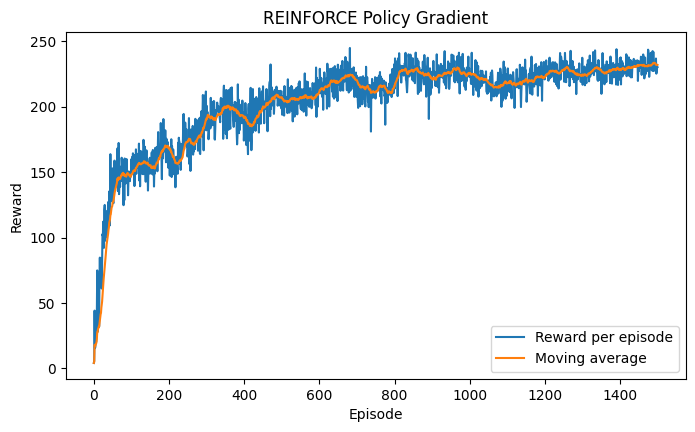

In [ ]:
plot_curve(re_pg, mv_pg, title='REINFORCE Policy Gradient')

In [ ]:
re_pg_var, mv_pg_var, net_pg_var = train_reinforce(
    env_name='MultiStockReturn-v0', episodes=1500, use_baseline=False,
    var=True, lr=1e-3, entropy_start=0.02, entropy_end=0.005,
    csv_filename='reinforce_var.csv'
)

Memulai pelatihan REINFORCE-VAR di MultiStockReturn-v0.
Menggunakan perangkat: cpu
[REINFORCE-VAR] Ep 25/1500 | R:121.2 | Avg(20): 40.6 | Ent:0.0197 | Risk: VAR
[REINFORCE-VAR] Ep 50/1500 | R:122.2 | Avg(20): 144.7 | Ent:0.0193 | Risk: VAR
[REINFORCE-VAR] Ep 75/1500 | R:148.8 | Avg(20): 116.0 | Ent:0.0189 | Risk: VAR
[REINFORCE-VAR] Ep 100/1500 | R:19.5 | Avg(20): 64.3 | Ent:0.0186 | Risk: VAR
[REINFORCE-VAR] Ep 125/1500 | R:95.8 | Avg(20): 122.7 | Ent:0.0182 | Risk: VAR
[REINFORCE-VAR] Ep 150/1500 | R:124.1 | Avg(20): 102.3 | Ent:0.0179 | Risk: VAR
[REINFORCE-VAR] Ep 175/1500 | R:68.0 | Avg(20): 73.6 | Ent:0.0175 | Risk: VAR
[REINFORCE-VAR] Ep 200/1500 | R:117.2 | Avg(20): 86.2 | Ent:0.0172 | Risk: VAR
[REINFORCE-VAR] Ep 225/1500 | R:134.5 | Avg(20): 94.5 | Ent:0.0168 | Risk: VAR
[REINFORCE-VAR] Ep 250/1500 | R:45.9 | Avg(20): 74.7 | Ent:0.0164 | Risk: VAR
[REINFORCE-VAR] Ep 275/1500 | R:99.5 | Avg(20): 92.9 | Ent:0.0161 | Risk: VAR
[REINFORCE-VAR] Ep 300/1500 | R:135.8 | Avg(20): 107

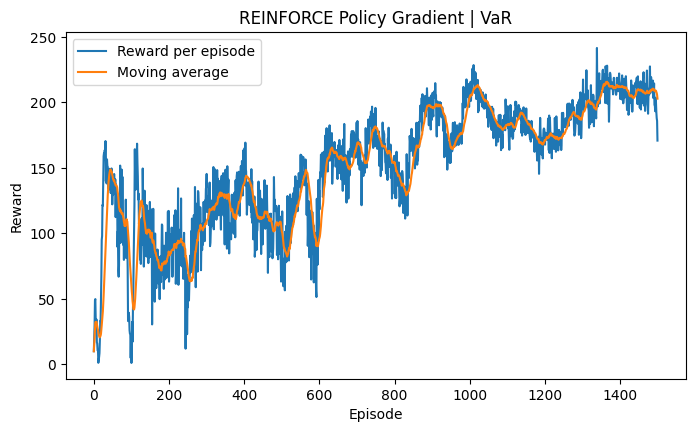

In [ ]:
plot_curve(re_pg_var, mv_pg_var, title='REINFORCE Policy Gradient | VaR')

In [ ]:
re_pg_cvar, mv_pg_cvar, net_pg_cvar = train_reinforce(
    env_name='MultiStockReturn-v0', episodes=1500, use_baseline=False,
    cvar=True, lr=1e-3, entropy_start=0.02, entropy_end=0.005,
    csv_filename='reinforce_cvar.csv'
)

Memulai pelatihan REINFORCE-CVAR di MultiStockReturn-v0.
Menggunakan perangkat: cpu
[REINFORCE-CVAR] Ep 25/1500 | R:124.3 | Avg(20): 40.3 | Ent:0.0197 | Risk: CVAR
[REINFORCE-CVAR] Ep 50/1500 | R:104.7 | Avg(20): 135.6 | Ent:0.0193 | Risk: CVAR
[REINFORCE-CVAR] Ep 75/1500 | R:144.9 | Avg(20): 128.4 | Ent:0.0189 | Risk: CVAR
[REINFORCE-CVAR] Ep 100/1500 | R:44.0 | Avg(20): 103.6 | Ent:0.0186 | Risk: CVAR
[REINFORCE-CVAR] Ep 125/1500 | R:94.7 | Avg(20): 112.7 | Ent:0.0182 | Risk: CVAR
[REINFORCE-CVAR] Ep 150/1500 | R:158.9 | Avg(20): 129.7 | Ent:0.0179 | Risk: CVAR
[REINFORCE-CVAR] Ep 175/1500 | R:99.6 | Avg(20): 95.3 | Ent:0.0175 | Risk: CVAR
[REINFORCE-CVAR] Ep 200/1500 | R:128.7 | Avg(20): 106.8 | Ent:0.0172 | Risk: CVAR
[REINFORCE-CVAR] Ep 225/1500 | R:69.5 | Avg(20): 96.2 | Ent:0.0168 | Risk: CVAR
[REINFORCE-CVAR] Ep 250/1500 | R:32.3 | Avg(20): 55.4 | Ent:0.0164 | Risk: CVAR
[REINFORCE-CVAR] Ep 275/1500 | R:89.8 | Avg(20): 90.9 | Ent:0.0161 | Risk: CVAR
[REINFORCE-CVAR] Ep 300/1500

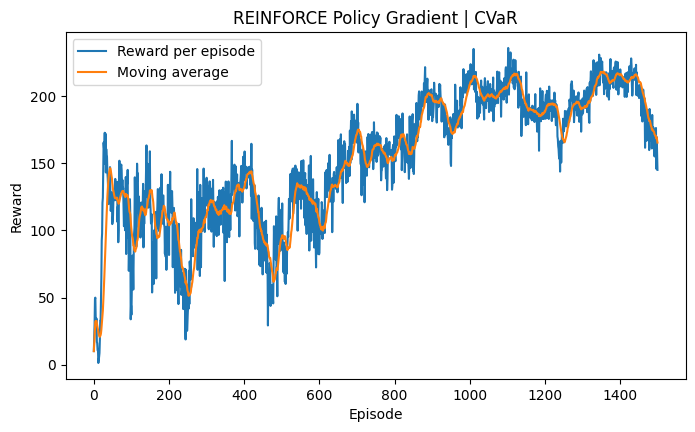

In [ ]:
plot_curve(re_pg_cvar, mv_pg_cvar, title='REINFORCE Policy Gradient | CVaR')

In [ ]:
re_pg_evar, mv_pg_evar, net_pg_evar = train_reinforce(
    env_name='MultiStockReturn-v0', episodes=1500, use_baseline=False,
    evar=True, lr=1e-3, entropy_start=0.02, entropy_end=0.005,
    csv_filename='reinforce_evar.csv'
)

Memulai pelatihan REINFORCE-EVAR di MultiStockReturn-v0.
Menggunakan perangkat: cpu
[REINFORCE-EVAR] Ep 25/1500 | R:169.0 | Avg(20): 169.8 | Ent:0.0197 | Risk: EVAR
[REINFORCE-EVAR] Ep 50/1500 | R:213.4 | Avg(20): 189.6 | Ent:0.0193 | Risk: EVAR
[REINFORCE-EVAR] Ep 75/1500 | R:254.9 | Avg(20): 233.6 | Ent:0.0189 | Risk: EVAR
[REINFORCE-EVAR] Ep 100/1500 | R:238.5 | Avg(20): 242.9 | Ent:0.0186 | Risk: EVAR
[REINFORCE-EVAR] Ep 125/1500 | R:233.5 | Avg(20): 241.5 | Ent:0.0182 | Risk: EVAR
[REINFORCE-EVAR] Ep 150/1500 | R:220.7 | Avg(20): 219.5 | Ent:0.0179 | Risk: EVAR
[REINFORCE-EVAR] Ep 175/1500 | R:225.3 | Avg(20): 225.6 | Ent:0.0175 | Risk: EVAR
[REINFORCE-EVAR] Ep 200/1500 | R:230.9 | Avg(20): 230.3 | Ent:0.0172 | Risk: EVAR
[REINFORCE-EVAR] Ep 225/1500 | R:247.8 | Avg(20): 239.2 | Ent:0.0168 | Risk: EVAR
[REINFORCE-EVAR] Ep 250/1500 | R:247.0 | Avg(20): 249.6 | Ent:0.0164 | Risk: EVAR
[REINFORCE-EVAR] Ep 275/1500 | R:232.4 | Avg(20): 243.5 | Ent:0.0161 | Risk: EVAR
[REINFORCE-EVAR] 

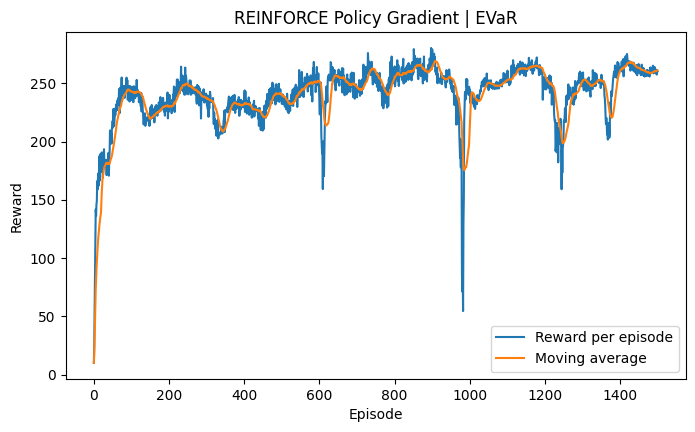

In [ ]:
plot_curve(re_pg_evar, mv_pg_evar, title='REINFORCE Policy Gradient | EVaR')

# Actor Critic (A2C)

In [ ]:
class ActorCriticNet(nn.Module):
    def __init__(self, obs_dim, act_dim, hidden=256):
        super().__init__()
        self.body = nn.Sequential(nn.Linear(obs_dim, hidden), nn.ReLU(),
                                  nn.Linear(hidden, hidden), nn.ReLU())
        self.pi_head = nn.Linear(hidden, act_dim)
        self.v_head  = nn.Linear(hidden, 1)
    def forward(self, x):
        h = self.body(x)
        dist = torch.distributions.Categorical(logits=self.pi_head(h))
        v    = self.v_head(h).squeeze(-1)
        return dist, v

def train_actor_critic_batched(env_name='CartPole-v1', episodes=1200, gamma=0.99, seed=7,
                               opt_name='adam', lr=1e-3, weight_decay=0.0, hidden=256,
                               value_loss_coeff=0.7, entropy_start=0.02, entropy_end=0.005,
                               grad_clip=0.5, render=False, window=20):
    set_seed(seed)
    device   = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    env      = gym.make(env_name)
    obs_dim  = env.observation_space.shape[0]
    act_dim  = env.action_space.n
    stnorm   = RunningNorm()

    net   = ActorCriticNet(obs_dim, act_dim, hidden).to(device)
    opt   = make_optimizer(net.parameters(), opt_name=opt_name, lr=lr, weight_decay=weight_decay)
    meter = Meter(window=window)

    for ep in range(episodes):
        obs = reset_env(env, seed+ep)
        done, total_r = False, 0.0
        logps, values, rewards, entros = [], [], [], []
        next_values, dones = [], []

        while not done:
            stnorm.update(obs)
            obs_t = torch.tensor(stnorm.norm(obs), dtype=torch.float32, device=device).unsqueeze(0)
            dist, v = net(obs_t)
            a = dist.sample()
            logps.append(dist.log_prob(a).squeeze(0))
            entros.append(dist.entropy().squeeze(0))
            values.append(v.squeeze(0))

            nobs, r, done, _ = step_env(env, a.item())
            rewards.append(float(r))
            total_r += r

            if done:
                nv = torch.tensor(0.0, dtype=torch.float32, device=device)
            else:
                nobs_t = torch.tensor(stnorm.norm(nobs), dtype=torch.float32, device=device).unsqueeze(0)
                _, nv = net(nobs_t); nv = nv.squeeze(0)
            next_values.append(nv.detach())
            dones.append(done)
            obs = nobs

        targets = []
        for r, nv, d in zip(rewards, next_values, dones):
            targets.append(torch.tensor(r, dtype=torch.float32, device=device) + (0.0 if d else gamma * nv))
        targets = torch.stack(targets)
        values_t = torch.stack(values)
        deltas = targets - values_t

        beta = linear_schedule(entropy_start, entropy_end, ep, episodes-1)
        actor_loss  = -(torch.stack(logps) * deltas.detach()).sum()
        critic_loss = (deltas.pow(2)).sum() * value_loss_coeff
        entropy_loss = -beta * torch.stack(entros).sum()
        loss = actor_loss + critic_loss + entropy_loss

        opt.zero_grad(); loss.backward()
        if grad_clip is not None:
            nn.utils.clip_grad_norm_(net.parameters(), grad_clip)
        opt.step()

        meter.push(total_r)
        if (ep+1) % 50 == 0:
            avg = np.mean(meter.rewards[-meter.window:]) if meter.rewards else total_r
            print(f'[A2C-B] Ep {ep+1}/{episodes} | R:{total_r:.1f} | Avg({meter.window}): {avg:.1f} | Ent:{beta:.4f}')

    env.close()
    return meter.rewards, meter.moving_avg(), net

In [ ]:
# --- Actor-Critic Network ---

class ActorCriticNet(nn.Module):
    """Jaringan Actor-Critic dengan body shared."""
    def __init__(self, obs_dim, act_dim, hidden=256):
        super().__init__()
        # Badan jaringan (shared feature extractor)
        self.body = nn.Sequential(nn.Linear(obs_dim, hidden), nn.ReLU(),
                                  nn.Linear(hidden, hidden), nn.ReLU())
        # Head untuk Policy (Aktor)
        self.pi_head = nn.Linear(hidden, act_dim)
        # Head untuk Value (Kritik)
        self.v_head  = nn.Linear(hidden, 1)

    def forward(self, x):
        """Pass maju: menghitung distribusi kebijakan dan nilai-V."""
        h = self.body(x)
        # Policy: Menggunakan Categorical Distribution untuk ruang aksi diskrit
        dist = torch.distributions.Categorical(logits=self.pi_head(h))
        # Value: Squeeze untuk output skalar
        v    = self.v_head(h).squeeze(-1)
        return dist, v

# --- Risk-Sensitive Training Function ---

def train_actor_critic_batched(env_name='CartPole-v1', episodes=1200, gamma=0.99, seed=7,
                               opt_name='adam', lr=1e-3, weight_decay=0.0, hidden=256,
                               value_loss_coeff=0.7, entropy_start=0.02, entropy_end=0.005,
                               grad_clip=0.5, render=False, window=20,
                               var=False, cvar=False, evar=False, risk_level=0.1, risk_beta=0.5,
                               csv_filename='a2c_risk_log.csv'):
    """
    Melatih Actor-Critic (A2C) dengan dukungan ukuran risiko dan menyimpan log ke CSV.
    """

    # --- Pengecekan Kendala Risiko ---
    risk_options = [var, cvar, evar]
    active_risks = sum(risk_options)

    if active_risks > 1:
        print("-------------------------------------------------------------------------------------------")
        print("ERROR: Hanya boleh memilih SATU ukuran risiko (VAR, CVAR, atau EVAR) aktif pada satu waktu.")
        print("-------------------------------------------------------------------------------------------")
        return [], [], None

    if var: risk_measure = 'var'
    elif cvar: risk_measure = 'cvar'
    elif evar: risk_measure = 'evar'
    else: risk_measure = None

    if risk_measure:
        print(f"Memulai pelatihan A2C dengan fokus risiko: {risk_measure.upper()}")

    # --- Setup Awal ---
    set_seed(seed)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Menggunakan perangkat: {device}")

    env = gym.make(env_name)
    obs_dim = env.observation_space.shape[0]
    act_dim = env.action_space.n
    stnorm = RunningNorm()

    net = ActorCriticNet(obs_dim, act_dim, hidden).to(device)
    opt = make_optimizer(net.parameters(), opt_name=opt_name, lr=lr, weight_decay=weight_decay)
    meter = Meter(window=window)

    log_data = [] # Data log dikumpulkan di sini

    # --- Training Loop ---
    for ep in range(episodes):
        obs = reset_env(env, seed+ep)
        done, total_r = False, 0.0

        logps, values, rewards, entros = [], [], [], []
        next_values, dones = [], []

        while not done:
            if render: env.render()

            stnorm.update(obs)
            obs_t = torch.tensor(stnorm.norm(obs), dtype=torch.float32, device=device).unsqueeze(0)

            dist, v = net(obs_t)
            a = dist.sample()

            logps.append(dist.log_prob(a).squeeze(0))
            entros.append(dist.entropy().squeeze(0))
            values.append(v.squeeze(0))

            nobs, r, done, truncated, info = env.step(a.item())
            done = done or truncated
            rewards.append(float(r))
            total_r += r

            if done:
                nv = torch.tensor(0.0, dtype=torch.float32, device=device)
            else:
                nobs_t = torch.tensor(stnorm.norm(nobs), dtype=torch.float32, device=device).unsqueeze(0)
                _, nv = net(nobs_t); nv = nv.squeeze(0).detach()

            next_values.append(nv)
            dones.append(done)
            obs = nobs

        # --- Perhitungan Loss ---
        targets = []
        for r, nv, d in zip(rewards, next_values, dones):
            r_t = torch.tensor(r, dtype=torch.float32, device=device)
            targets.append(r_t + (0.0 if d else gamma * nv))

        targets = torch.stack(targets)
        values_t = torch.stack(values)
        deltas = targets - values_t

        risk_deltas = deltas

        # Penyesuaian Resiko
        if risk_measure == 'cvar':
            sorted_deltas, _ = torch.sort(deltas, descending=False)
            k = int(risk_level * len(deltas))
            if k == 0: k = 1
            cvar_mask = deltas <= sorted_deltas[k-1]
            risk_deltas = deltas * cvar_mask.float()
        elif risk_measure == 'evar':
            risk_deltas = deltas * torch.exp(risk_beta * deltas.detach())
        elif risk_measure == 'var':
            median_delta = torch.quantile(deltas, 0.5)
            var_mask = deltas <= median_delta
            risk_deltas = deltas * var_mask.float()

        actor_loss  = -(torch.stack(logps) * risk_deltas.detach()).sum()
        critic_loss = (deltas.pow(2)).sum() * value_loss_coeff
        beta = linear_schedule(entropy_start, entropy_end, ep, episodes-1)
        entropy_loss = -beta * torch.stack(entros).sum()
        loss = actor_loss + critic_loss + entropy_loss

        # --- Backpropagation ---
        opt.zero_grad(); loss.backward()
        if grad_clip is not None:
            nn.utils.clip_grad_norm_(net.parameters(), grad_clip)
        opt.step()

        # --- Logging dan Monitoring ---
        meter.push(total_r)

        # Dapatkan rata-rata bergerak terbaru dari Meter
        current_avg = meter.get_last_moving_avg()

        # Kumpulkan data log untuk episode saat ini
        log_data.append({
            'episode': ep + 1,
            'reward': total_r,
            'moving_avg': current_avg,
            # Gunakan .item() untuk memindahkan tensor loss ke CPU dan mengubahnya menjadi float
            'actor_loss': actor_loss.item(),
            'critic_loss': critic_loss.item(),
            'entropy_loss': entropy_loss.item(),
            'total_loss': loss.item(),
            'entropy_beta': beta,
            'risk_measure': risk_measure if risk_measure else 'None',
        })

        if (ep+1) % 50 == 0:
            mode = f"| Risk: {risk_measure.upper()}" if risk_measure else ""
            print(f'[A2C-B] Ep {ep+1}/{episodes} | R:{total_r:.1f} | Avg({meter.window}): {current_avg:.1f} | Ent:{beta:.4f} {mode}')

    env.close()

    # SAVE LOG DATA KE CSV FILE
    if csv_filename and log_data:
        fieldnames = log_data[0].keys()
        try:
            with open(csv_filename, 'w', newline='') as csvfile:
                writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
                writer.writeheader()
                writer.writerows(log_data)
            print(f"\n[A2C-B] Pelatihan Selesai. Data log disimpan ke: {csv_filename}")
        except Exception as e:
            print(f"\n[A2C-B] ERROR saat menyimpan CSV: {e}")

    # PERBAIKAN: Mengembalikan list lengkap dari semua rata-rata bergerak
    return meter.rewards, meter.get_all_moving_avgs(), net

- Ubah `episodes` kecil dulu untuk tes cepat; naikkan jika diperlukan.  
- Ganti `opt_name` untuk mencoba optimizer lain: `"adam"`, `"adamw"`, `"rmsprop"`.
- Atur `entropy_coeff` untuk mendorong eksplorasi.
- `moving_avg_window` mengatur lebar rata‑rata bergerak untuk plot.


## A2C - Risk Free

In [ ]:
re_ac, mv_ac, net_ac = train_actor_critic_batched(
    env_name='MultiStockReturn-v0', episodes=1500, lr=1e-3,
    value_loss_coeff=0.7, entropy_start=0.02, entropy_end=0.005,
    csv_filename='a2c_standard.csv'
)

Menggunakan perangkat: cpu
[A2C-B] Ep 50/1500 | R:231.7 | Avg(20): 188.8 | Ent:0.0195 
[A2C-B] Ep 100/1500 | R:267.5 | Avg(20): 246.3 | Ent:0.0190 
[A2C-B] Ep 150/1500 | R:247.2 | Avg(20): 251.4 | Ent:0.0185 
[A2C-B] Ep 200/1500 | R:256.4 | Avg(20): 251.3 | Ent:0.0180 
[A2C-B] Ep 250/1500 | R:255.9 | Avg(20): 259.3 | Ent:0.0175 
[A2C-B] Ep 300/1500 | R:265.0 | Avg(20): 260.0 | Ent:0.0170 
[A2C-B] Ep 350/1500 | R:261.8 | Avg(20): 261.5 | Ent:0.0165 
[A2C-B] Ep 400/1500 | R:266.0 | Avg(20): 260.2 | Ent:0.0160 
[A2C-B] Ep 450/1500 | R:267.4 | Avg(20): 264.3 | Ent:0.0155 
[A2C-B] Ep 500/1500 | R:270.1 | Avg(20): 265.6 | Ent:0.0150 
[A2C-B] Ep 550/1500 | R:263.6 | Avg(20): 263.6 | Ent:0.0145 
[A2C-B] Ep 600/1500 | R:260.9 | Avg(20): 262.6 | Ent:0.0140 
[A2C-B] Ep 650/1500 | R:268.8 | Avg(20): 266.2 | Ent:0.0135 
[A2C-B] Ep 700/1500 | R:264.4 | Avg(20): 264.8 | Ent:0.0130 
[A2C-B] Ep 750/1500 | R:262.8 | Avg(20): 262.4 | Ent:0.0125 
[A2C-B] Ep 800/1500 | R:264.9 | Avg(20): 267.9 | Ent:0.0120

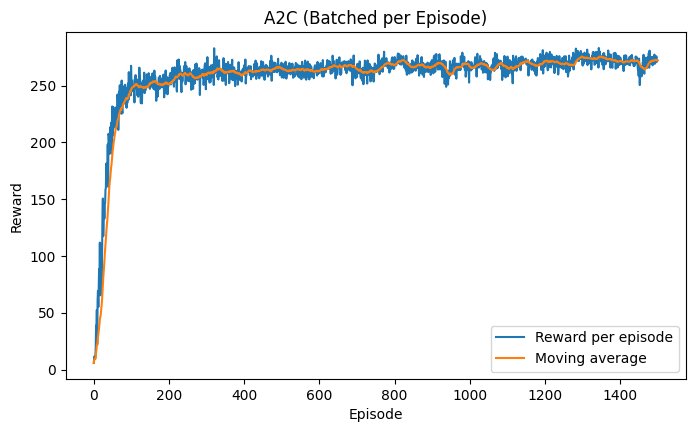

In [ ]:
plot_curve(re_ac, mv_ac, title='A2C (Batched per Episode)')

## A2C - VaR

In [ ]:
re_ac_var, mv_ac_var, net_ac_var = train_actor_critic_batched(
    env_name='MultiStockReturn-v0', episodes=1500, lr=1e-3, var=True,
    value_loss_coeff=0.7, entropy_start=0.02, entropy_end=0.005,
    csv_filename='a2c_var.csv'
)

Memulai pelatihan A2C dengan fokus risiko: VAR
Menggunakan perangkat: cpu
[A2C-B] Ep 50/1500 | R:214.4 | Avg(20): 127.1 | Ent:0.0195 | Risk: VAR
[A2C-B] Ep 100/1500 | R:207.2 | Avg(20): 197.4 | Ent:0.0190 | Risk: VAR
[A2C-B] Ep 150/1500 | R:231.0 | Avg(20): 222.2 | Ent:0.0185 | Risk: VAR
[A2C-B] Ep 200/1500 | R:221.7 | Avg(20): 212.9 | Ent:0.0180 | Risk: VAR
[A2C-B] Ep 250/1500 | R:232.9 | Avg(20): 233.6 | Ent:0.0175 | Risk: VAR
[A2C-B] Ep 300/1500 | R:237.3 | Avg(20): 235.0 | Ent:0.0170 | Risk: VAR
[A2C-B] Ep 350/1500 | R:245.3 | Avg(20): 241.6 | Ent:0.0165 | Risk: VAR
[A2C-B] Ep 400/1500 | R:251.1 | Avg(20): 247.8 | Ent:0.0160 | Risk: VAR
[A2C-B] Ep 450/1500 | R:252.2 | Avg(20): 250.9 | Ent:0.0155 | Risk: VAR
[A2C-B] Ep 500/1500 | R:258.1 | Avg(20): 256.0 | Ent:0.0150 | Risk: VAR
[A2C-B] Ep 550/1500 | R:259.6 | Avg(20): 256.1 | Ent:0.0145 | Risk: VAR
[A2C-B] Ep 600/1500 | R:256.9 | Avg(20): 255.4 | Ent:0.0140 | Risk: VAR
[A2C-B] Ep 650/1500 | R:247.6 | Avg(20): 256.9 | Ent:0.0135 | R

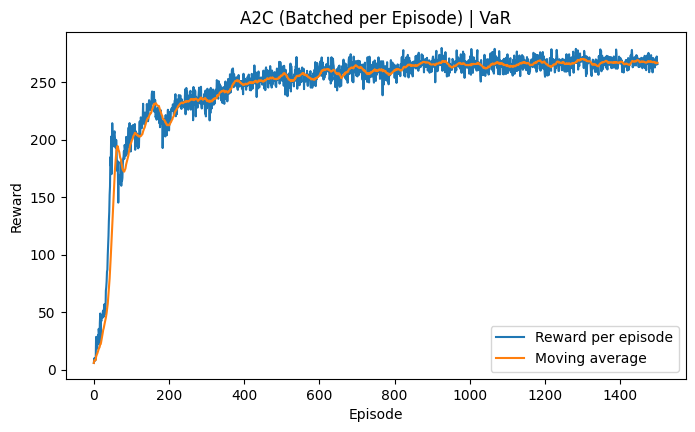

In [ ]:
plot_curve(re_ac_var, mv_ac_var, title='A2C (Batched per Episode) | VaR')

## A2C - CVaR

In [ ]:
re_ac_cvar, mv_ac_cvar, net_ac_cvar = train_actor_critic_batched(
    env_name='MultiStockReturn-v0', episodes=1500, lr=1e-3, cvar=True,
    value_loss_coeff=0.7, entropy_start=0.02, entropy_end=0.005,
    csv_filename='a2c_cvar.csv'
)

Memulai pelatihan A2C dengan fokus risiko: CVAR
Menggunakan perangkat: cpu
[A2C-B] Ep 50/1500 | R:22.2 | Avg(20): 10.2 | Ent:0.0195 | Risk: CVAR
[A2C-B] Ep 100/1500 | R:137.7 | Avg(20): 155.1 | Ent:0.0190 | Risk: CVAR
[A2C-B] Ep 150/1500 | R:208.9 | Avg(20): 195.8 | Ent:0.0185 | Risk: CVAR
[A2C-B] Ep 200/1500 | R:199.0 | Avg(20): 199.1 | Ent:0.0180 | Risk: CVAR
[A2C-B] Ep 250/1500 | R:192.1 | Avg(20): 191.4 | Ent:0.0175 | Risk: CVAR
[A2C-B] Ep 300/1500 | R:195.9 | Avg(20): 198.9 | Ent:0.0170 | Risk: CVAR
[A2C-B] Ep 350/1500 | R:198.1 | Avg(20): 202.3 | Ent:0.0165 | Risk: CVAR
[A2C-B] Ep 400/1500 | R:205.3 | Avg(20): 207.8 | Ent:0.0160 | Risk: CVAR
[A2C-B] Ep 450/1500 | R:213.4 | Avg(20): 215.2 | Ent:0.0155 | Risk: CVAR
[A2C-B] Ep 500/1500 | R:221.8 | Avg(20): 220.0 | Ent:0.0150 | Risk: CVAR
[A2C-B] Ep 550/1500 | R:215.3 | Avg(20): 215.0 | Ent:0.0145 | Risk: CVAR
[A2C-B] Ep 600/1500 | R:225.2 | Avg(20): 218.4 | Ent:0.0140 | Risk: CVAR
[A2C-B] Ep 650/1500 | R:224.1 | Avg(20): 231.7 | Ent

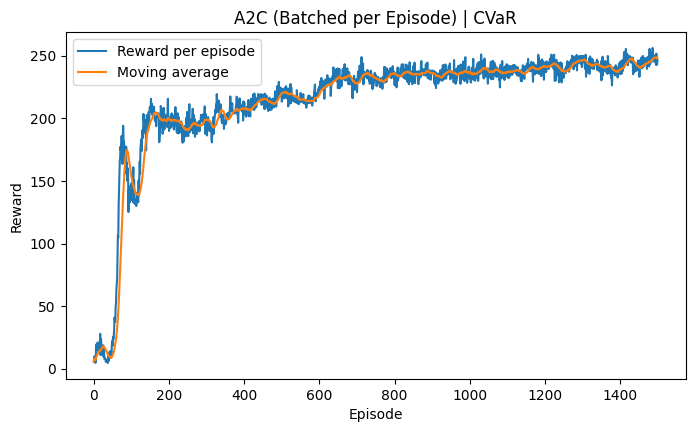

In [ ]:
plot_curve(re_ac_cvar, mv_ac_cvar, title='A2C (Batched per Episode) | CVaR')

## A2C - EVaR

In [ ]:
re_ac_evar, mv_ac_evar, net_ac_evar = train_actor_critic_batched(
    env_name='MultiStockReturn-v0', episodes=1500, lr=1e-3, evar=True,
    value_loss_coeff=0.7, entropy_start=0.02, entropy_end=0.005,
    csv_filename='a2c_evar.csv'
)

Memulai pelatihan A2C dengan fokus risiko: EVAR
Menggunakan perangkat: cpu
[A2C-B] Ep 50/1500 | R:166.3 | Avg(20): 138.6 | Ent:0.0195 | Risk: EVAR
[A2C-B] Ep 100/1500 | R:157.2 | Avg(20): 175.0 | Ent:0.0190 | Risk: EVAR
[A2C-B] Ep 150/1500 | R:216.4 | Avg(20): 223.3 | Ent:0.0185 | Risk: EVAR
[A2C-B] Ep 200/1500 | R:238.9 | Avg(20): 222.7 | Ent:0.0180 | Risk: EVAR
[A2C-B] Ep 250/1500 | R:241.3 | Avg(20): 244.5 | Ent:0.0175 | Risk: EVAR
[A2C-B] Ep 300/1500 | R:226.4 | Avg(20): 230.5 | Ent:0.0170 | Risk: EVAR
[A2C-B] Ep 350/1500 | R:257.0 | Avg(20): 249.8 | Ent:0.0165 | Risk: EVAR
[A2C-B] Ep 400/1500 | R:232.3 | Avg(20): 236.0 | Ent:0.0160 | Risk: EVAR
[A2C-B] Ep 450/1500 | R:239.7 | Avg(20): 240.7 | Ent:0.0155 | Risk: EVAR
[A2C-B] Ep 500/1500 | R:259.4 | Avg(20): 248.3 | Ent:0.0150 | Risk: EVAR
[A2C-B] Ep 550/1500 | R:263.1 | Avg(20): 255.8 | Ent:0.0145 | Risk: EVAR
[A2C-B] Ep 600/1500 | R:256.8 | Avg(20): 260.1 | Ent:0.0140 | Risk: EVAR
[A2C-B] Ep 650/1500 | R:252.0 | Avg(20): 264.0 | E

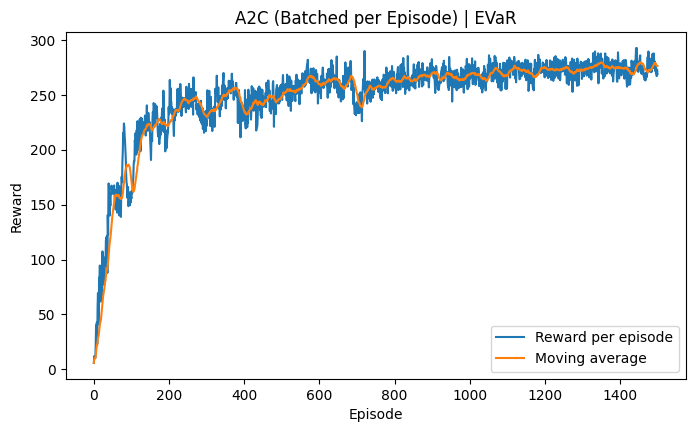

In [ ]:
plot_curve(re_ac_evar, mv_ac_evar, title='A2C (Batched per Episode) | EVaR')

# Comparison

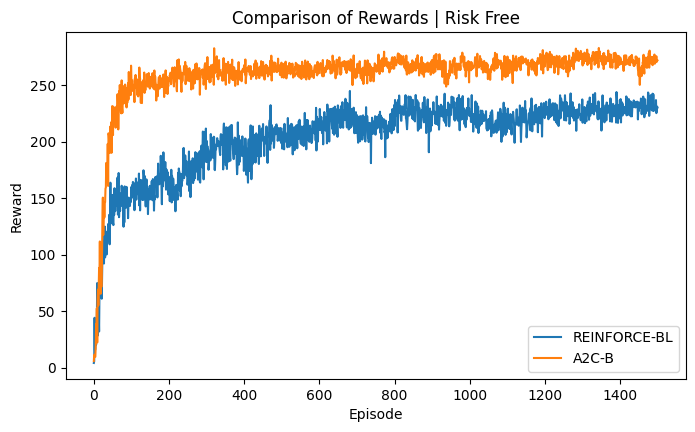

In [ ]:
plt.figure(figsize=(8,4.5))
plt.plot(re_pg, label='REINFORCE-BL')
plt.plot(re_ac, label='A2C-B')
plt.title('Comparison of Rewards | Risk Free')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.legend()
plt.show()

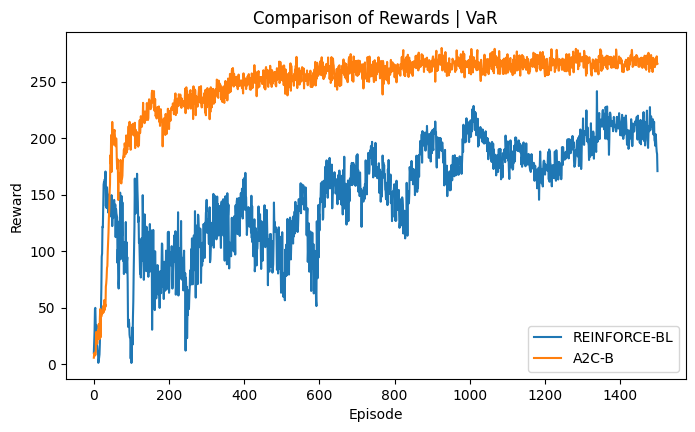

In [ ]:
plt.figure(figsize=(8,4.5))
plt.plot(re_pg_var, label='REINFORCE-BL')
plt.plot(re_ac_var, label='A2C-B')
plt.title('Comparison of Rewards | VaR')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.legend()
plt.show()

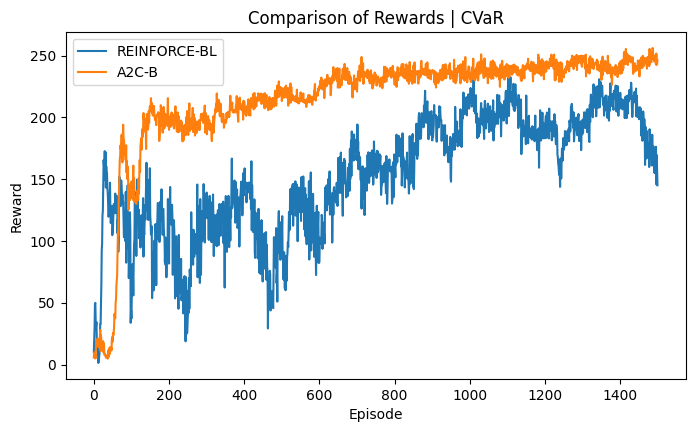

In [ ]:
plt.figure(figsize=(8,4.5))
plt.plot(re_pg_cvar, label='REINFORCE-BL')
plt.plot(re_ac_cvar, label='A2C-B')
plt.title('Comparison of Rewards | CVaR')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.legend()
plt.show()

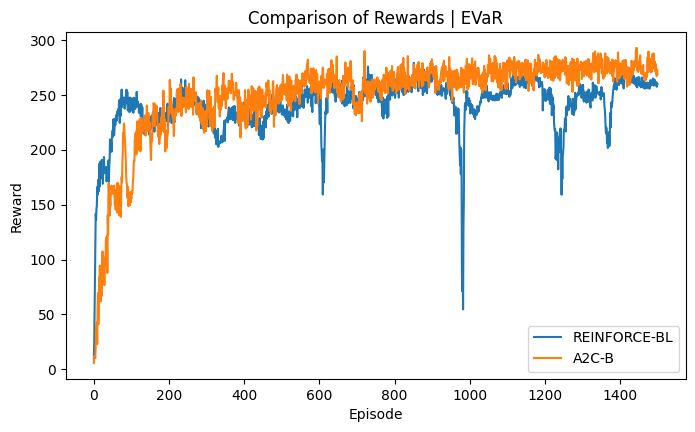

In [ ]:
plt.figure(figsize=(8,4.5))
plt.plot(re_pg_evar, label='REINFORCE-BL')
plt.plot(re_ac_evar, label='A2C-B')
plt.title('Comparison of Rewards | EVaR')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.legend()
plt.show()